In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Files
import input_net
import utils

# Packages
from os import path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

# Transformers
from transformers import AlbertConfig, AlbertForSequenceClassification, AlbertTokenizer
from transformers import BartConfig, BartForSequenceClassification, BartTokenizer
from transformers import BertConfig, BertForSequenceClassification, BertTokenizer
from transformers import CamembertConfig, CamembertForSequenceClassification, CamembertTokenizer
from transformers import DistilBertConfig, DistilBertForSequenceClassification, DistilBertTokenizer
from transformers import FlaubertConfig, FlaubertForSequenceClassification, FlaubertTokenizer
from transformers import RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer
from transformers import XLMConfig, XLMForSequenceClassification, XLMTokenizer
from transformers import XLMRobertaConfig, XLMRobertaForSequenceClassification, XLMRobertaTokenizer
from transformers import XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer
from sklearn.model_selection import train_test_split

from transformers import AdamW, get_linear_schedule_with_warmup

Using TensorFlow backend.


/home/danasour/Documents/UPC/6Q/POE/Projects/ProjecteFinal/ProjectQuora/utils.py:342: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/home/danasour/Documents/UPC/6Q/POE/Projects/ProjecteFinal/ProjectQuora/utils.py:343: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/home/danasour/Documents/UPC/6Q/POE/Projects/ProjecteFinal/ProjectQuora/utils.py:345: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/home/danasour/Documents/UPC/6Q/POE/Projects/ProjecteFinal/ProjectQuora/utils.py:346: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_v

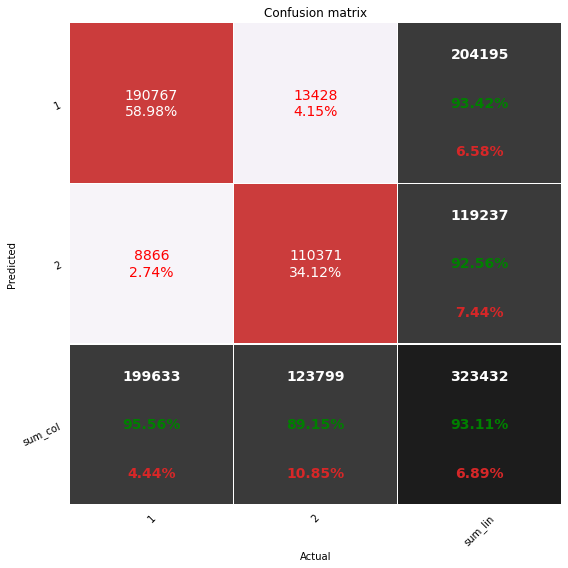

In [3]:
a = [[190767, 8866], [13428, 110371]]
utils.confussion_matrix(a)

## Models

In [4]:
#                       Model                                   Tokenizer               Pretrained weights shortcut 
MODEL_CLASSES = {
    'albert': (         AlbertForSequenceClassification,        AlbertTokenizer,        'albert-large-v2'),
    'bart': (           BartForSequenceClassification,          BartTokenizer,          'bart-large'),
    'bert': (           BertForSequenceClassification,          BertTokenizer,          'bert-base-uncased'),
    'camembert': (      CamembertForSequenceClassification,     CamembertTokenizer,     'camembert-base'),
    'distilbert': (     DistilBertForSequenceClassification,    DistilBertTokenizer,    'distilbert-base-uncased'),
    'flaubert': (       FlaubertForSequenceClassification,      FlaubertTokenizer,      'flaubert-base-uncased'),
    'roberta': (        RobertaForSequenceClassification,       RobertaTokenizer,       'roberta-base'),
    'xlm': (            XLMForSequenceClassification,           XLMTokenizer,           'xlm-mlm-en-2048'),
    'xlm_roberta':(     XLMRobertaForSequenceClassification,    XLMRobertaTokenizer,    'xlm-roberta-base'),
    'xlnet': (          XLNetForSequenceClassification,         XLNetTokenizer,         'xlnet-base-cased')
}

args = {
    'model_type': 'xlnet',
    'do_train': True,
    'do_eval': True,
    'max_seq_length': 60,
    'batch_size': 8, 
    'epochs': 1,
    'learning_rate': 1e-3,
    'num_training_steps': 10,
    'num_warmup_steps': 10,
    'max_grad_norm': 1.0
}

model_class, tokenizer_class, pretrained_model = MODEL_CLASSES[args['model_type']]

## Input Generation

In [5]:
TRAIN = "data/train.csv"
TEST = "data/test.csv"
INPUT_NET = 'data/input' + str(args['max_seq_length']) + '_' + pretrained_model + '.csv'

if not path.exists(INPUT_NET):
    df = input_net.create_input(TRAIN, INPUT_NET, tokenizer_class, pretrained_model, args)
else:
    df = pd.read_csv(INPUT_NET)

Dataset length: 404290
Pretrained model used: xlnet-base-cased
Maximum sequence length: 60
Input saved: data/input60_xlnet-base-cased.csv


## Net Functions -> quan funcioni tot cridar-ho desde net.py


In [9]:
def batch_generator(data, target, batch_size):
    data = np.array(data)[:1000]
    target = np.array(target)[:1000]
    nsamples = len(data)
    perm = np.random.permutation(nsamples)
    for i in range(0, nsamples, batch_size):
        batch_idx = perm[i:i+batch_size]
        if target is not None:
            yield data[batch_idx,:], target[batch_idx]
        else:
            yield data[batch_idx], None

def training(model, train_data, train_target, epoch, args):

    criterion = nn.CrossEntropyLoss(reduction='mean')
    optimizer = AdamW(model.parameters(), lr=args['learning_rate'], correct_bias=False)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=args['num_warmup_steps'],
                                                num_training_steps=args['num_training_steps'])
    b = 0
    ncorrect = 0
    total_loss = 0

    batch_size = args['batch_size']
    
    for X, y in batch_generator(train_data, train_target, batch_size):
        model.train()
        X_i, X_s, X_p, y = utils.ToTensor(X,y)
        
        out = model(input_ids=X_i, attention_mask=X_s, X_p, y)[1]
        
        loss = criterion(out, y)
        loss.backward()
        total_loss += loss
        #torch.nn.utils.clip_grad_norm_(model.parameters(), args['max_grad_norm'])  # Gradient clipping 
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        out = F.softmax(out, dim=1)

        ncorrect += (torch.max(out, 1)[1] == y).sum().item()
        print("Training Loss :", loss.item())
        b += 1
    total_loss /= len(train_data)
    acc = ncorrect/len(train_data) * 100
    print("Training Accuracy :", loss.item())
    return acc, loss


def validation(model, eval_data, eval_target, args):
    criterion = nn.CrossEntropyLoss(reduction='mean')

    b = 0
    ncorrect = 0
    total_loss = 0

    batch_size = args['batch_size']
    model.eval()
    for X, y in batch_generator(eval_data, eval_target, batch_size):
        
        X_i, X_s, X_p, y = utils.ToTensor(X,y)
        
        out = model(input_ids=X_i, token_type_ids=X_s, attention_mask=X_p, labels=y)[1]
        
        loss = criterion(out, y)   
        total_loss += loss
        out = F.softmax(out, dim=1)
        ncorrect += (torch.max(out, 1)[1] == y).sum().item()
        print("Iteration", b, "of epoch", epoch, "complete", "Validation Loss :", loss.item())
        b += 1

    total_loss /= len(eval_data)
    acc = ncorrect/len(eval_data) * 100
    print("Validation Accuracy :", loss.item())
    return acc, loss

def build(learn_data, model_class, pretrained_model, args):
    model = model_class.from_pretrained(pretrained_model, num_labels=2)
    print("Model loaded")

    epochs = args['epochs']

    X_train, X_val, y_train, y_val = train_test_split(learn_data.iloc[:,:-1], learn_data.iloc[:,-1],                                                            test_size=0.2, random_state=47)

    train_acc = [None]*epochs
    train_loss = [None]*epochs
    val_acc = [None]*epochs
    val_los = [None]*epochs

    for epoch in range(epochs):
        print("Training...")
        t_acc, t_loss = training(model, X_train, y_train, epoch, args)
             
        train_acc[epoch] = t_acc
        train_loss[epoch] = t_loss
        
        print("Validation...")
        v_acc, v_loss = validation(model, X_val, y_val, epoch, args)
        val_acc[epoch] = v_acc
        val_loss[epoch] = v_loss

    model.save_pretrained('trained/models/' + pretrained_model)  
    tokenizer.save_pretrained('trained/tokenizers/' + pretrained_model)  

    return train_acc, val_acc

def test(model, test_data, args):
    ncorrect = 0
    total_loss = 0

    batch_size = args['batch_size']

    for X, _ in batch_generator(test_data, batch_size):
        X_i, X_s, X_p = utils.ToTensor(X,y=None)
        
        out = model(input_ids=X_i, token_type_ids=X_s, attention_mask=X_p)[0]
        out = F.softmax(out, dim=1)

        ncorrect += (torch.max(out, 1)[1] == y).sum().item()

    acc = ncorrect/len(test_data) * 100
    return acc

## Learning

In [10]:
train_acc, val_acc = build(df, model_class, pretrained_model, args)

Model loaded
Training...


ValueError: You cannot specify both input_ids and inputs_embeds at the same time

## Proves

In [5]:
model = model_class.from_pretrained(pretrained_model, num_labels=2)
X = np.array(df.iloc[:,:-1])
y = np.array(df.iloc[:,-1])
X_i, X_s, X_p, y = utils.ToTensor(X,y)

# Predict
Predictions = model(input_ids=X_i[:1000],token_type_ids=X_s[:1000],attention_mask=X_p[:1000])
# Training
#Predictions = model(input_ids=X_i[:5],token_type_ids=X_s[:5],attention_mask=X_p[:5], labels=y[:5])

RuntimeError: [enforce fail at CPUAllocator.cpp:64] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 215040000 bytes. Error code 12 (Cannot allocate memory)
